# Libraries, Headers and Stuff

In [1]:
import sys
sys.path.append('../../src')


In [2]:
N_SENTENCES = 50000
TEST_RATIO = .1
WINDOW_SIZE = 16
N_EPOCHS = 5
CACHED = True
N_STATES = 32
SAMPLES_VERIFY = 8
BATCH_SIZE = 32

In [3]:
import datetime
import os

FOLDER_OUT = 'Parenthesis-' + str(datetime.datetime.today())
if not os.path.exists(FOLDER_OUT):
    os.makedirs(FOLDER_OUT)

In [4]:
import numpy as np
import keras

Using TensorFlow backend.


In [5]:
%load_ext rpy2.ipython

In [6]:
import random
random.seed(55555)

# Creates Dataset

In [7]:
import utils.grammar as gram
reload(gram)
grammar = [('S0', '0 S0 | ( S1 )'),
           ('S1', '1 S1 | ( S2 )'),
           ('S2', '2 S2 | ( S3 )'),
           ('S3', '3 S3 | ( S4 )'),
           ('S4', 'S4 S4 | 4')]
gram_obj = gram.GrammarUseCase(grammar, 'S0')

In [8]:
import utils.preprocess as pre
reload(pre)

# Generates data
train_sequence = gram_obj.gen_sequence(N_SENTENCES)
test_sequence = gram_obj.gen_sequence(int(N_SENTENCES * TEST_RATIO))

raw_train_sequence, raw_test_sequence, char2int, int2char = pre.encode_split(train_sequence, test_sequence)

print 'Training smybols:', len(raw_train_sequence)
print 'Testing smybols:', len(raw_test_sequence)
print 'Size vocabulay:', len(char2int)

Generating raw text size: 50000
Generated sequence - 607083 characters
Generating raw text size: 5000
Generated sequence - 60861 characters
Encoding
Total vocabulary size:  7
Training smybols: 607083
Testing smybols: 60861
Size vocabulay: 7


In [18]:
import numpy as np
import utils.preprocess as pre
reload(pre)

# Preprocesses training
# SPLITS
X_train_raw = raw_train_sequence[:-1]
y_train_raw = raw_train_sequence[1:]
# ENCODES
X_train = keras.utils.to_categorical(X_train_raw)
y_train = keras.utils.to_categorical(y_train_raw)
# SHUFFLES
train_indices = pre.shuffle_indices(len(X_train_raw), BATCH_SIZE)
y_train = y_train[train_indices]
# EXPANDS
X_train = X_train[train_indices,np.newaxis,:]

# Preprocesses testing
# SPLITS
X_test_raw = raw_test_sequence[:-1]
y_test_raw = raw_test_sequence[1:]
# ENCODES
X_test = keras.utils.to_categorical(X_test_raw)
y_test = keras.utils.to_categorical(y_test_raw)
# SHUFFLES
test_indices = pre.shuffle_indices(len(X_test_raw), BATCH_SIZE)
X_test = X_test[test_indices, np.newaxis,:]
y_test = y_test[test_indices]

print "Training data:"
print "X:", X_train.shape
print "y:", y_train.shape

print "Test data:"
print "X:", X_test.shape
print "y:", y_test.shape


# Recovers the original training data
X_test_sequence = test_sequence[:X_test.shape[0]]
y_test_sequence = test_sequence[1:X_test.shape[0]+1]
print 'Test sequences:', X_test_sequence[:5], y_test_sequence[:5]
print 'length:', len(X_test_sequence), len(y_test_sequence)

import pickle
f = open("sequence.pkl", "wb")
pickle.dump({"X": X_test_sequence, "y": y_test_sequence}, f)


Training data:
X: (607072, 1, 7)
y: (607072, 7)
Test data:
X: (60832, 1, 7)
y: (60832, 7)
Test sequences: ['(', '(', '(', '3', '('] ['(', '(', '3', '(', '4']
length: 60832 60832


# Creates the model

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM,SimpleRNN
from keras.layers import Lambda
from keras import regularizers

from controllers.mylstm_legacy import MYLSTM

in_dim = X_train.shape[1:]
out_dim = y_train.shape[1]

model = Sequential()
model.add(MYLSTM(N_STATES, stateful=True,
                         batch_size=BATCH_SIZE,
                           input_shape=in_dim,
                          activity_regularizer = regularizers.l1(0.01)))
model.add(Dense(out_dim, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [11]:
from keras.models import load_model
from controllers.mylstm_legacy import MYLSTM

if not CACHED:
    for i in range(N_EPOCHS):
        model.reset_states()
        history = model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=1,
                            verbose=1,
                            shuffle=False)
        model.save('models/parentheses_stateful_reg_mylstm')
else:
    model = load_model('models/parentheses_stateful_reg_mylstm',
                       custom_objects={'MYLSTM':MYLSTM})

In [12]:
model.reset_states()
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

60256/60832 [============================>.] - ETA: 0s('Test score:', 0.47418262301966241)
('Test accuracy:', 0.74079431877958968)


In [13]:
# Generate samples
import generator as gen

print gen.complete_sentence_stateful('(1(2(3(', model, 64, char2int, int2char,BATCH_SIZE)
print gen.complete_sentence_stateful('((((4))', model, 64, char2int, int2char, BATCH_SIZE)

Dimensions of sentence after encoding: (32, 7, 7)
Dimensions of sentence after generation: (32, 72, 7)
(1(2(3((((4)44)))))((2((4))))0((2((4))))(1(22(3(4))))(1(2((4))))(1(2(3(4
Dimensions of sentence after encoding: (32, 7, 7)
Dimensions of sentence after generation: (32, 72, 7)
((((4))0(((3(4))))0((((4))))((((4))))0(1(2(33(4))))(1(2(3(44))))(1(22(33


# Extracts all kind of features

In [14]:
import features as feat
reload(feat)

bin_feature = gram_obj.gen_bin_feat()
bin_trig_feature = gram_obj.gen_bin_feat_trig()
alphabet = feat.alphabet()

#features = [bin_feature, bin_trig_feature, alphabet]
features = [bin_feature]

In [17]:
reload(feat)

feature_frame_x = feat.FeatureFrame(features, X_test_sequence)
feature_frame_x.extract()

feature_frame_y = feat.FeatureFrame(features, y_test_sequence)
feature_frame_y.extract()

print'Features for test sequence:'
print feature_frame_x.names
print feature_frame_x.values[:15,:]

print 'Features for test sequence labels:'
print feature_frame_y.names
print feature_frame_y.values[:15,:]

import pickle
pickle.dump(feature_frame_y.values, open("features.pkl", "w"))


Generating feature scores
Running feature 0 out of 1
Parsed 0 symbols out of 60832
Parsed 1000 symbols out of 60832
Parsed 2000 symbols out of 60832
Parsed 3000 symbols out of 60832
Parsed 4000 symbols out of 60832
Parsed 5000 symbols out of 60832
Parsed 6000 symbols out of 60832
Parsed 7000 symbols out of 60832
Parsed 8000 symbols out of 60832
Parsed 9000 symbols out of 60832
Parsed 10000 symbols out of 60832
Parsed 11000 symbols out of 60832
Parsed 12000 symbols out of 60832
Parsed 13000 symbols out of 60832
Parsed 14000 symbols out of 60832
Parsed 15000 symbols out of 60832
Parsed 16000 symbols out of 60832
Parsed 17000 symbols out of 60832
Parsed 18000 symbols out of 60832
Parsed 19000 symbols out of 60832
Parsed 20000 symbols out of 60832
Parsed 21000 symbols out of 60832
Parsed 22000 symbols out of 60832
Parsed 23000 symbols out of 60832
Parsed 24000 symbols out of 60832
Parsed 25000 symbols out of 60832
Parsed 26000 symbols out of 60832
Parsed 27000 symbols out of 60832
Parsed 2

# Extracts the Hidden States

In [17]:
import extractor
reload(extractor)

## for code comprehension only
# from IPython.core.debugger import Tracer
# Tracer()()

ex=extractor.Extractor(model, [0])
states = ex.get_states(X_test, batch_size=BATCH_SIZE, unshuffle=True)

# for graphing activations
import pickle
pickle.dump(states, open("states.pkl", "w"))

nn_config = ex.get_structure()
nn_offsets = ex.get_offets()

print 'states shape:', states.shape
print ''
print 'config:', nn_config
print 'offets:', nn_offsets

BEWARE _ ONLY SUPPORTS CONSECUTIVE LAYER IDS STARTING AT 0
Creates spy models
... for id 0 : <controllers.mylstm_legacy.MYLSTM object at 0x125264350>
Gets the activations for the hidden states
Gets structure
Gets offets
WARNING +++ NOT SUITABLE FOR NON_FORWARD LAYERS
Gets structure
states shape: (60832, 32)

config: [('<controllers.mylstm_legacy.MYLSTM object at 0x125264350>', 1, 32)]
offets: {(0, 0): 0}


## Plots the activations

In [18]:
feat_names, feat_mat = feature_frame_x.data
feat_names

['prod_S3', 'prod_S2', 'prod_S1', 'prod_S0', 'prod_S4']

/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


 [1] "(" "(" "(" "3" "(" "4" "4" "4" ")" ")" ")" ")" "(" "(" "2" "(" "(" "4" ")"
[20] ")" ")" ")" "(" "1" "(" "2" "(" "(" "4" ")" ")" ")" ")" "0" "(" "(" "(" "("
[39] "4" "4" ")" ")" ")" ")" "0" "(" "1" "(" "2" "("


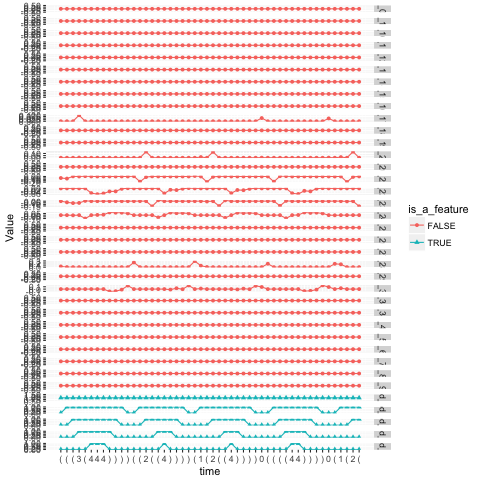

In [19]:
%%R -i feat_names,feat_mat,states,X_test_sequence,FOLDER_OUT

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names

to_plot <- filter(to_plot, Series %in%states_col_names | is_a_feature)
MAX_TIME <- 50 
to_plot <- filter(to_plot, time <= MAX_TIME)

labels <- X_test_sequence[1:MAX_TIME]
print(labels)

p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")

ggsave(paste0(FOLDER_OUT, '/activations.pdf'), p, width=40, height=49)
p

# Inspects - correlation

In [20]:
import scores
import inspector as ip

insp = ip.Inspector(nn_config, nn_offsets)
mi_scores, names = insp.inspect(states, feature_frame_x, scores.Correlation())

Computing attribution scores
Feture matrix dimensions: (60832, 5)
States dimensions: (60832, 32)
Computing score for feature 0: prod_S3
Layer 0
Timestep 0
Scoring neurons 0 to 31
Computing score for feature 1: prod_S2
Layer 0
Timestep 0
Scoring neurons 0 to 31
Computing score for feature 2: prod_S1
Layer 0
Timestep 0
Scoring neurons 0 to 31
Computing score for feature 3: prod_S0
Layer 0
Timestep 0
Scoring neurons 0 to 31
Computing score for feature 4: prod_S4
Layer 0
Timestep 0
Scoring neurons 0 to 31


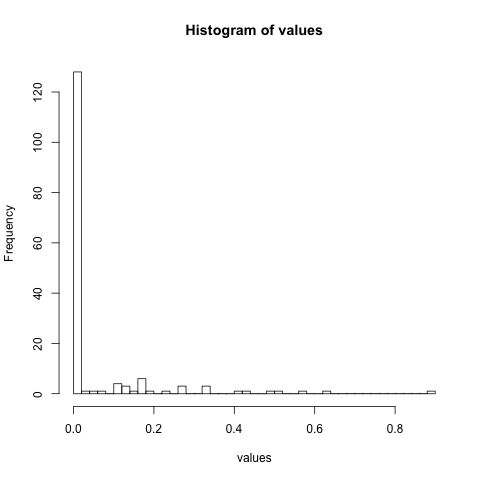

In [21]:
%%R -i mi_scores
values <- c(mi_scores)
hist(values, breaks=45)

In [22]:
feature_neurons = insp.filter_attributions(ip.filter_threshold_abs(.05))
non_feature_neurons = insp.not_attributed()

feature_neurons

{'prod_S0': [],
 'prod_S1': [(0, 0, 2),
  (0, 0, 3),
  (0, 0, 17),
  (0, 0, 21),
  (0, 0, 22),
  (0, 0, 23),
  (0, 0, 24),
  (0, 0, 28)],
 'prod_S2': [(0, 0, 2),
  (0, 0, 3),
  (0, 0, 21),
  (0, 0, 22),
  (0, 0, 23),
  (0, 0, 24),
  (0, 0, 28)],
 'prod_S3': [(0, 0, 2),
  (0, 0, 3),
  (0, 0, 17),
  (0, 0, 21),
  (0, 0, 22),
  (0, 0, 23),
  (0, 0, 24),
  (0, 0, 28)],
 'prod_S4': [(0, 0, 2),
  (0, 0, 3),
  (0, 0, 17),
  (0, 0, 21),
  (0, 0, 22),
  (0, 0, 23),
  (0, 0, 24),
  (0, 0, 28)]}

In [23]:
# Writes results
fname = FOLDER_OUT + '/attributions'
hnames = [repr(n) for n in names]
header = ','.join(hnames)
np.savetxt(fname, mi_scores, delimiter=',', header=header, comments='')

# And preps for plotting
is_selected = np.zeros_like(mi_scores)
for j, fname in enumerate(names):
    for i in insp.attributed_columns[fname]:
        is_selected[i,j] = 1

/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning:
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  Ignoring unknown parameters: aes

  res = super(Function, self).__call__(*new_args, **new_kwargs)


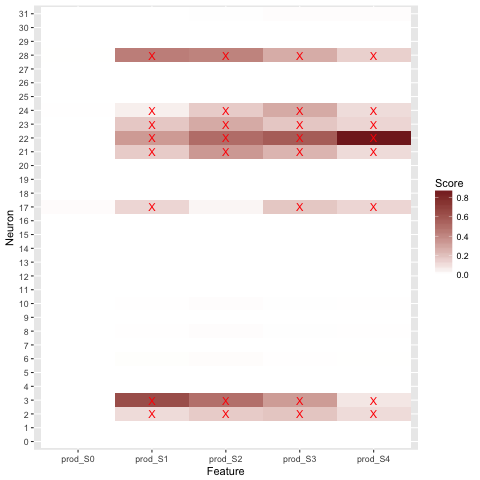

In [24]:
%%R -i mi_scores,names,N_STATES,is_selected,FOLDER_OUT

library(ggplot2)
library(scales) 
library(dplyr)
library(tidyr)

# Gets scores
data <- as.data.frame(mi_scores)
names(data) <- names
data[['Neuron']] <- factor(0:(nrow(data)-1),
                           levels = 0:(nrow(data)-1),
                           labels = as.character(0:(nrow(data)-1)))
data <- gather(data, key='Feature', value='Score', -Neuron)

# Gets neuron selection
sel <- as.data.frame(is_selected)
names(sel) <- names
sel[['Neuron']] <- factor(0:(nrow(sel)-1),
                           levels = 0:(nrow(sel)-1),
                           labels = as.character(0:(nrow(sel)-1)))
sel <- gather(sel, key='Feature', value='selected', -Neuron)
sel$selected <- ifelse(sel$selected == 1, 'X', '')

# joins
to_plot <- inner_join(data,sel, by = c("Neuron", "Feature"))

p <- ggplot(to_plot, aes(x=Feature, y=Neuron, fill=Score, label=selected)) + 
                geom_bin2d(aes='identity') +
                geom_text(color='red') +
                scale_fill_gradient2(midpoint=median(to_plot$Score),
                                    low = muted("blue"), mid = "white",high = muted("red"),
                                    limits=c(0,NA))

ggsave(paste0(FOLDER_OUT, '/attribution_map.pdf'), p, width=40, height=40)

p

# Does the Unit Test

In [25]:
import scores
out_base = insp.test(states, feature_frame_x, non_feature_neurons, scores.LogRegF1())
out_base

Computing scores for prod_S0
Computing scores for prod_S1


/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Computing scores for prod_S2
Computing scores for prod_S3
Computing scores for prod_S4


{'prod_S0': 0.73127057069449142,
 'prod_S1': 0.29315768255735125,
 'prod_S2': 0.1495050172608256,
 'prod_S3': 0.0,
 'prod_S4': 0.082303103656955132}

In [26]:
# With the correct neuronss 
out = insp.test(states, feature_frame_x, feature_neurons, scores.LogRegF1())
out

Computing scores for prod_S0
ERROR Cant compute score: Found array with 0 feature(s) (shape=(60832, 0)) while a minimum of 1 is required.
Computing scores for prod_S1
Computing scores for prod_S2
Computing scores for prod_S3
Computing scores for prod_S4


{'prod_S0': 0,
 'prod_S1': 0.98307812094189906,
 'prod_S2': 0.999350027195122,
 'prod_S3': 0.9262904239222518,
 'prod_S4': 0.99982491975369492}

In [27]:
# Prepares and saves a df
testnames = out.keys()
baseline = [out_base[t] for t in testnames]
candidate = [out[t] for t in testnames]

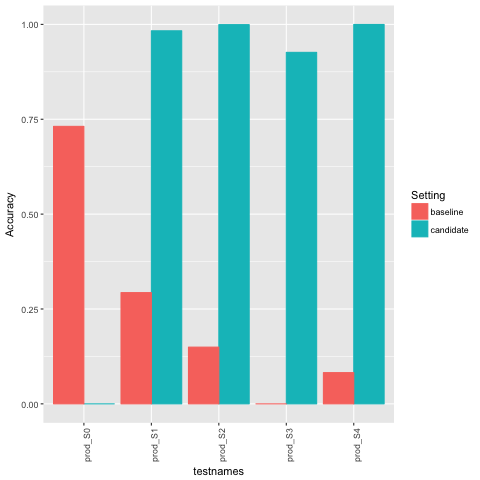

In [28]:
%%R -i testnames,baseline,candidate,FOLDER_OUT

toplot <- data.frame(testnames, baseline, candidate)
write.csv(toplot, paste0(FOLDER_OUT,'/test_results'),row.names = FALSE)

dat <- gather(toplot, key='Setting', value='Accuracy', -testnames)

p <- ggplot(dat, aes(x=testnames, y=Accuracy, fill=Setting, color=Setting)) +
        geom_bar(stat='identity', position='dodge') +
        theme(axis.text.x = element_text(angle=90))

print(p)
ggsave(paste0(FOLDER_OUT, '/test_scores.pdf'), p, width=40, height=10)

## Verifies with the Kevinizer

In [29]:
from controllers import control
reload(control)
import verify
reload(verify)
verifier = verify.Verifier(model, feature_neurons, non_feature_neurons)
v_scores = verifier.run(feature_frame_y, X_test, y_test, BATCH_SIZE, sample_size=SAMPLES_VERIFY)

*** Testing the neurons for feature prod_S3
* Computing original accuracy
* Computing baseline accuracies
Round 0


/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ian.huang/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0: [0.59361013061598367], 1: [0.65168134449477044]}, 'candidate': {0: [0.1462508930601166, 0.30422489559004789, 0.1462508930601166, 0.02452384632674029, 0.02452384632674029, 0.30422489559004789, 0.30422489559004789, 0.1462508930601166], 1: [0.10011988810443587, 0.60290637955191007, 0.10011988810443587, 0.00053000604415759725, 0.00053000604415759725, 0.60290637955191007, 0.60290637955191007, 0.10011988810443587]}, 'baseline': {0: [0.077836042087459326, 0.099726046236555038, 0.59361013061598367, 0.24582412145188751, 0.33903349968287994, 0.59361013061598367, 0.20298672089487857, 0.59361013061598367], 1: [0.29633728651695906, 0.059284885852367637, 0.65168134449477044, 0.2023306647294576, 0.40169741754544375, 0.65168134449477044, 0.41736740910513559, 0.65168134449477044]}}
*** Testing the neurons for feature prod_S2
* Computin

In [30]:
for feat in v_scores:
    print '---', feat
    for setup in v_scores[feat]:
        print '-', setup
        for y in v_scores[feat][setup]:
            s = v_scores[feat][setup][y]
            print y, ':', 'mean:', np.mean(s), '- sd:', np.std(s) 

--- prod_S0
- original
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
- candidate
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
- baseline
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
--- prod_S1
- original
0 : mean: 0.717374088358 - sd: 0.0
1 : mean: 0.595930495171 - sd: 0.0
- candidate
0 : mean: 0.403425482899 - sd: 0.275511710226
1 : mean: 0.180438141093 - sd: 0.180192835832
- baseline
0 : mean: 0.269417841922 - sd: 0.192730304575
1 : mean: 0.428698916293 - sd: 0.108206819416
--- prod_S2
- original
0 : mean: 0.655532106407 - sd: 0.0
1 : mean: 0.612898070561 - sd: 0.0
- candidate
0 : mean: 0.184219581565 - sd: 0.15236687931
1 : mean: 0.190448196677 - sd: 0.223268455832
- baseline
0 : mean: 0.239367957422 - sd: 0.177659329319
1 : mean: 0.348180654752 - sd: 0.187980100368
--- prod_S3
- original
0 : mean: 0.593610130616 - sd: 0.0
1 : mean: 0.651681344495 - sd: 0.0
- candidate
0 : mean: 0.175059382325 - sd: 0.1106022

In [31]:
verifier.test_diff()

Testing for feature prod_S0
Value 0 : Ttest_indResult(statistic=nan, pvalue=nan)
Value 1 : Ttest_indResult(statistic=nan, pvalue=nan)
Testing for feature prod_S1
Value 0 : Ttest_indResult(statistic=1.0544842215891252, pvalue=0.31157495668065849)
Value 1 : Ttest_indResult(statistic=-3.1250232095064217, pvalue=0.0092225710783976345)
Testing for feature prod_S2
Value 0 : Ttest_indResult(statistic=-0.6234141653912858, pvalue=0.54326565591645393)
Value 1 : Ttest_indResult(statistic=-1.4298408743381239, pvalue=0.17532392156254081)
Testing for feature prod_S3
Value 0 : Ttest_indResult(statistic=-1.8874375373488437, pvalue=0.086614183208187936)
Value 1 : Ttest_indResult(statistic=-1.1929382614260799, pvalue=0.25373450728296182)
Testing for feature prod_S4
Value 0 : Ttest_indResult(statistic=-1.6461623123570168, pvalue=0.12206752572861378)
Value 1 : Ttest_indResult(statistic=-0.62935939023163534, pvalue=0.54000372109652728)


{('prod_S0', 0): Ttest_indResult(statistic=nan, pvalue=nan),
 ('prod_S0', 1): Ttest_indResult(statistic=nan, pvalue=nan),
 ('prod_S1',
  0): Ttest_indResult(statistic=1.0544842215891252, pvalue=0.31157495668065849),
 ('prod_S1',
  1): Ttest_indResult(statistic=-3.1250232095064217, pvalue=0.0092225710783976345),
 ('prod_S2',
  0): Ttest_indResult(statistic=-0.6234141653912858, pvalue=0.54326565591645393),
 ('prod_S2',
  1): Ttest_indResult(statistic=-1.4298408743381239, pvalue=0.17532392156254081),
 ('prod_S3',
  0): Ttest_indResult(statistic=-1.8874375373488437, pvalue=0.086614183208187936),
 ('prod_S3',
  1): Ttest_indResult(statistic=-1.1929382614260799, pvalue=0.25373450728296182),
 ('prod_S4',
  0): Ttest_indResult(statistic=-1.6461623123570168, pvalue=0.12206752572861378),
 ('prod_S4',
  1): Ttest_indResult(statistic=-0.62935939023163534, pvalue=0.54000372109652728)}

In [32]:
import pandas as pd

out = None

for feat in v_scores:
    print '---', feat
    for setup in v_scores[feat]:
        print '-', setup
        for y in v_scores[feat][setup]:
            s = np.array(v_scores[feat][setup][y])
            print y, ':', 'mean:', np.mean(s), '- sd:', np.std(s) 
            s_y = np.repeat(y, len(s))
            s_setup = np.repeat(setup, len(s))
            s_feat = np.repeat(feat, len(s))
            df = pd.DataFrame({
                'acc' : s,
                'feat_val': s_y,
                'feature': s_feat,
                'setup' : s_setup
            })
            if out is None:
                out = df
            else:
                out = pd.concat([out, df], axis = 0)

print out
out.to_csv(FOLDER_OUT+'/kevinizers.csv',index=False)

--- prod_S0
- original
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
- candidate
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
- baseline
0 : mean: 0.460270774977 - sd: 0.0
1 : mean: 0.576697964419 - sd: 0.0
--- prod_S1
- original
0 : mean: 0.717374088358 - sd: 0.0
1 : mean: 0.595930495171 - sd: 0.0
- candidate
0 : mean: 0.403425482899 - sd: 0.275511710226
1 : mean: 0.180438141093 - sd: 0.180192835832
- baseline
0 : mean: 0.269417841922 - sd: 0.192730304575
1 : mean: 0.428698916293 - sd: 0.108206819416
--- prod_S2
- original
0 : mean: 0.655532106407 - sd: 0.0
1 : mean: 0.612898070561 - sd: 0.0
- candidate
0 : mean: 0.184219581565 - sd: 0.15236687931
1 : mean: 0.190448196677 - sd: 0.223268455832
- baseline
0 : mean: 0.239367957422 - sd: 0.177659329319
1 : mean: 0.348180654752 - sd: 0.187980100368
--- prod_S3
- original
0 : mean: 0.593610130616 - sd: 0.0
1 : mean: 0.651681344495 - sd: 0.0
- candidate
0 : mean: 0.175059382325 - sd: 0.1106022

# Introduces a bug

## Creates adversarial dataset

In [33]:
reload(gram)
reload(pre)

ADV_N_SENTENCES = int(.25 * N_SENTENCES)

# Creates new dataset
adv_grammar = [('S0', '0 S0 | ( S1 )'),
              ('S1', '1 S1 | ( S2 )'),
              ('S2', '4 S2 | ( S3 )'),
              ('S3', '3 S3 | ( S4 )'),
              ('S4', 'S4 S4 | 2')]
adv_gram_obj = gram.GrammarUseCase(adv_grammar, 'S0')


# Generates data
adv_train_sequence = adv_gram_obj.gen_sequence(ADV_N_SENTENCES)
adv_test_sequence = adv_gram_obj.gen_sequence(int(ADV_N_SENTENCES * TEST_RATIO))

adv_raw_train_sequence = [char2int[x] for x in adv_train_sequence]
adv_raw_test_sequence = [char2int[x] for x in adv_test_sequence]

print 'Training smybols:', len(adv_raw_train_sequence)
print 'Testing smybols:', len(adv_raw_test_sequence)

# Preprocesses
# SPLITS
adv_X_train_raw = adv_raw_train_sequence[:-1]
adv_y_train_raw = adv_raw_train_sequence[1:]
# ENCODES
adv_X_train = keras.utils.to_categorical(adv_X_train_raw)
adv_y_train = keras.utils.to_categorical(adv_y_train_raw)
# SHUFFLES
adv_train_indices = pre.shuffle_indices(len(adv_X_train_raw), BATCH_SIZE)
adv_y_train = adv_y_train[adv_train_indices]
# EXPANDS
adv_X_train = adv_X_train[adv_train_indices,np.newaxis,:]


# Preprocesses testing
# SPLITS
adv_X_test_raw = adv_raw_test_sequence[:-1]
adv_y_test_raw = adv_raw_test_sequence[1:]
# ENCODES
adv_X_test = keras.utils.to_categorical(adv_X_test_raw)
adv_y_test = keras.utils.to_categorical(adv_y_test_raw)
# SHUFFLES
adv_test_indices = pre.shuffle_indices(len(adv_X_test_raw), BATCH_SIZE)
adv_X_test = adv_X_test[adv_test_indices, np.newaxis,:]
adv_y_test = adv_y_test[adv_test_indices]

print "Training data:"
print "X:", adv_X_train.shape
print "y:", adv_y_train.shape

print "Test data:"
print "X:", adv_X_test.shape
print "y:", adv_y_test.shape


Generating raw text size: 12500
Generated sequence - 151942 characters
Generating raw text size: 1250
Generated sequence - 15208 characters
Training smybols: 151942
Testing smybols: 15208
Training data:
X: (151936, 1, 7)
y: (151936, 7)
Test data:
X: (15200, 1, 7)
y: (15200, 7)


## Makes the model drift!

In [34]:
model.save('models/healthy_copy')
hacked_model = load_model('models/healthy_copy',custom_objects={'MYLSTM':MYLSTM})

for i in range(N_EPOCHS):
    hacked_model.reset_states()
    history = hacked_model.fit(adv_X_train, adv_y_train,
                        batch_size=BATCH_SIZE,
                        epochs=1,
                        verbose=1,
                        shuffle=False)

Epoch 1/1
151936/151936 [==============================] - 38s - loss: 0.9266 - acc: 0.6547    
Epoch 1/1
151936/151936 [==============================] - 42s - loss: 0.7482 - acc: 0.6989    
Epoch 1/1
151936/151936 [==============================] - 41s - loss: 0.6175 - acc: 0.7287    
Epoch 1/1
151936/151936 [==============================] - 36s - loss: 0.5828 - acc: 0.7347    
Epoch 1/1
151936/151936 [==============================] - 36s - loss: 0.5599 - acc: 0.7351    


In [35]:
# old model
model.reset_states()
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print '\nBEFORE DRIFT - Test accuracy:', score[1]

hacked_model.reset_states()
score = hacked_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print '\nAFTER DRIFT - Test accuracy:', score[1]

60416/60832 [============================>.] - ETA: 0s
BEFORE DRIFT - Test accuracy: 0.74079431878
60576/60832 [============================>.] - ETA: 0s
AFTER DRIFT - Test accuracy: 0.441149395055


In [36]:
print gen.complete_sentence_stateful('(1(2(3(', hacked_model, 64, char2int, int2char,BATCH_SIZE)
print gen.complete_sentence_stateful('((((4))', hacked_model, 64, char2int, int2char, BATCH_SIZE)

NameError: name 'hacked_model' is not defined

# Does the Unit Test Again

In [37]:
hacked_ex=extractor.Extractor(hacked_model, [0])
hacked_states = ex.get_states(X_test, batch_size=BATCH_SIZE, unshuffle=True)

NameError: name 'hacked_model' is not defined

In [38]:
out_base = insp.test(hacked_states, feature_frame_x, feature_neurons, scores.LogRegF1())
print 'AFTER HACKING'
out_base

NameError: name 'hacked_states' is not defined

In [39]:
(((3)))((2))(1(2(3())))
01111100111001111111110

TypeError: 'int' object is not callable